# Import the Data

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import IsolationForest

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

from catboost import CatBoostClassifier

In [2]:
df = pd.read_parquet('../data/train_val_data.parquet', engine='fastparquet')
df_test = pd.read_parquet('../data/test_data.parquet', engine='fastparquet')

In [3]:
columns_to_drop = [
    'latitude', 'longitude',
    'pedestrian_location', 
    'pedestrian_action',
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 
    'age',
]

na_with_meaning = [
    'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type',
    'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other', 'motor_type_other',
    'sex', 'vehicle_category_simplified', 'vehicle_category_simplified_other', 
]

In [4]:
for x in [df, df_test]:
    # Encode Na Values -----------------------------------

    # Remove rows or columns with missing values that do not encode info.
    x.drop(columns=columns_to_drop, inplace=True)  
    x[x.columns.difference(na_with_meaning)] = x[x.columns.difference(na_with_meaning)].replace(-1, pd.NA)
    x[na_with_meaning] = x[na_with_meaning].fillna(-1)
    
    x.dropna(inplace=True)
    # Data Cleanup ---------------------------------------

In [5]:
categorical_unordered = ['location', 'type_of_collision', 'horizontal_alignment', 'infrastructure', 'accident_situation', 'position', 'sex', 
                         'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type', 
                         'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other', 
                         'motor_type_other', 'used_belt', 'used_helmet', 'used_child_restraint', 'used_airbag', 'vehicle_category_simplified', 'vehicle_category_simplified_other', 
                         'surface_quality_indicator', 'role', 'cluster']

categorical_ordered = {
    'time_of_day': pd.CategoricalDtype(['Morning_Rush', 'Midday', 'Evening_Rush', 'Night'], ordered=True),
    'day_of_week': pd.CategoricalDtype([0,1,2,3,4,5,6], ordered=True),
    'age_group': pd.CategoricalDtype(['Unknown', 'child_teen', 'young_adult', 'adult', 'middle_aged', 'senior'], ordered=True),
    'lighting_ordinal': pd.CategoricalDtype([0,1,2,3], ordered=True),
    'weather_ordinal': pd.CategoricalDtype([0,1,2,3,4], ordered=True),
    'injury_target': pd.CategoricalDtype([0,1,2], ordered=True),
    'reserved_lane_present': pd.CategoricalDtype(ordered=True),
    'impact_score': pd.CategoricalDtype(ordered=True),
    'impact_score_other': pd.CategoricalDtype(ordered=True),
    'impact_delta': pd.CategoricalDtype(ordered=True)
}

numeric = ['speed_limit']

df[categorical_unordered] = df[categorical_unordered].astype('category')
df_test[categorical_unordered] = df_test[categorical_unordered].astype('category')

df = df.astype(categorical_ordered)
df_test = df_test.astype(categorical_ordered)

df[numeric] = df[numeric].astype('int16')
df_test[numeric] = df_test[numeric].astype('int16')

In [6]:
X_train = df.drop(columns='injury_target')
y_train = df['injury_target']

X_test = df_test.drop(columns='injury_target')
y_test = df_test['injury_target']

In [7]:
cat_idx = [i for i, (col, dt) in enumerate(X_train.dtypes.items())
           if isinstance(dt, pd.CategoricalDtype)]

# 1) Build a numeric view of X_train for IsolationForest
cat_cols = [c for c in X_train.columns if isinstance(X_train[c].dtype, pd.CategoricalDtype)]
num_cols = [c for c in X_train.columns if c not in cat_cols]

iso_transformer = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
        ('num', 'passthrough', num_cols),
    ],
    remainder='drop'
)

X_train_iso = iso_transformer.fit_transform(X_train)

# 2) Isolation Forest on the numeric representation
pruner = IsolationForest(n_jobs=-1, random_state=42, n_estimators=1000)
mask = pruner.fit_predict(X_train_iso)   # 1 = inlier, -1 = outlier
inlier_mask = (mask == 1)

# Use the mask on the *original* X_train / y_train
X_train, y_train = X_train[inlier_mask], y_train[inlier_mask]

In [8]:
under_sampler = RandomUnderSampler(random_state=42, sampling_strategy='not minority')

X_train_rebalanced, y_train_rebalanced = under_sampler.fit_resample(X_train, y_train)
X_train_unbalanced, y_train_unbalanced = X_train, y_train
X_train, y_train = None, None # Reset to avoid mixups

# Model Evaluation

In [9]:
from evaluation import get_speed_rule_baseline_performance
baseline_results = get_speed_rule_baseline_performance(X_test, y_test)

Calculating rule-based baseline performance using column 'speed_limit'...

--- Rule-based Baseline (Speed Limit) Report ---
              precision    recall  f1-score   support

           0       0.50      0.64      0.56     51051
           1       0.34      0.30      0.32     39476
           2       0.16      0.08      0.10     17440

    accuracy                           0.42    107967
   macro avg       0.33      0.34      0.33    107967
weighted avg       0.39      0.42      0.40    107967

Baseline Weighted F1-Score: 0.3276
Baseline Weighted Cohen's Kappa: 0.0910
--------------------------------------------------


In [10]:
ord_cols = [c for c in categorical_ordered.keys() if c != 'injury_target']
num_cols = ['speed_limit', 'road_complexity_index']

transformer_ridge = ColumnTransformer([
    # OneHotEncode all categorical columns to avoid ordinal leakage
    ('cat_unordered', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_unordered),
    ('cat_ordered', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ord_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

In [11]:
pipeline_ridge_final = Pipeline(steps=[
    ('transform', transformer_ridge),
    ('classifier', RidgeClassifier(alpha=1.5))
])

In [12]:
pipeline_ridge_final.fit(X_train_rebalanced, y_train_rebalanced)
y_pred = pipeline_ridge_final.predict(X_test)

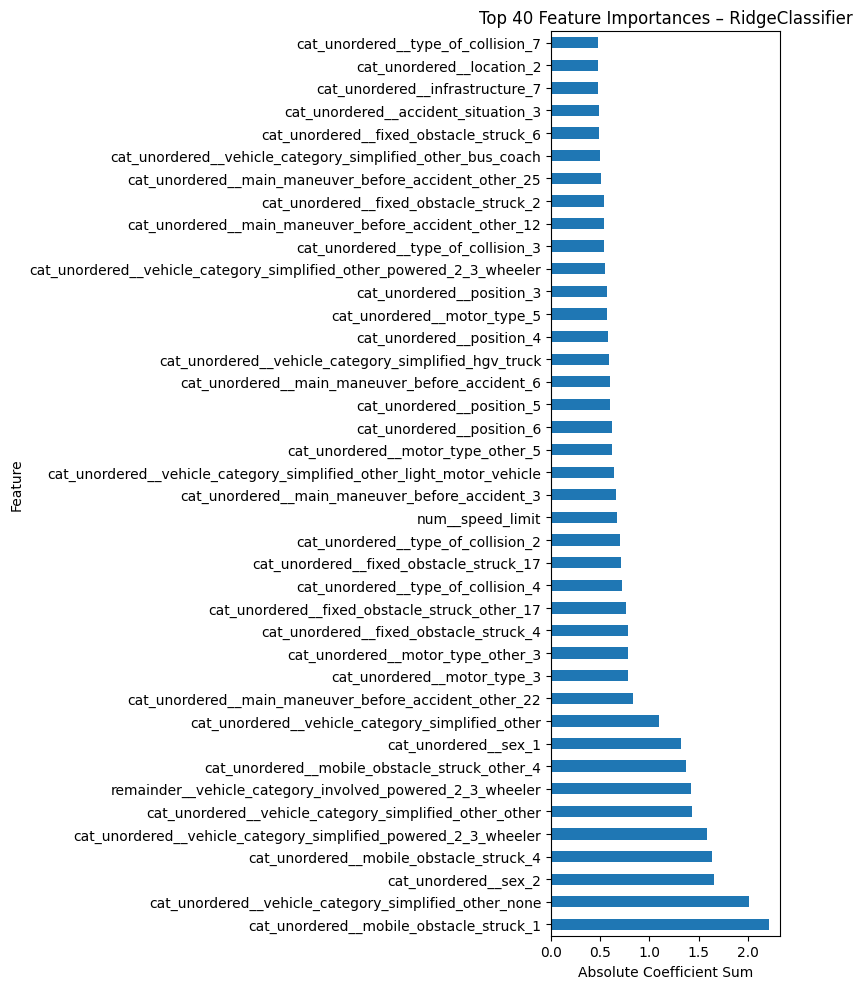

In [13]:
rf = pipeline_ridge_final.named_steps["classifier"]
pre = pipeline_ridge_final.named_steps["transform"]
feature_names = pre.get_feature_names_out()

# RidgeClassifier does not have feature_importances_. Using coef_ instead.
# Accessing the coef_ attribute for RidgeClassifier and ensuring it's in the correct shape
if hasattr(rf, 'coef_'):
    # For multiclass, coef_ can be (n_classes, n_features) or (n_features,)
    # Sum absolute coefficients across classes for overall importance if multiclass
    if rf.coef_.ndim > 1:
        importances = np.sum(np.abs(rf.coef_), axis=0)
    else:
        importances = np.abs(rf.coef_)
else:
    print("Classifier does not have 'coef_' attribute to determine importances.")
    importances = np.zeros(len(feature_names)) # Fallback to zeros if no coef_

forest_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(8, 10))
# Filter out zero importances before nlargest to avoid plotting non-informative features
non_zero_importances = forest_importances[forest_importances != 0]
if not non_zero_importances.empty:
    non_zero_importances.nlargest(40).plot(kind="barh")
    plt.title("Top 40 Feature Importances – RidgeClassifier")
    plt.xlabel("Absolute Coefficient Sum")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("No non-zero feature importances to plot.")

Calculating baseline (Most Frequent Class) performance...

--- Baseline (Most Frequent Class) Report ---
              precision    recall  f1-score   support

           0       0.47      1.00      0.64     51051
           1       0.00      0.00      0.00     39476
           2       0.00      0.00      0.00     17440

    accuracy                           0.47    107967
   macro avg       0.16      0.33      0.21    107967
weighted avg       0.22      0.47      0.30    107967

Baseline Weighted F1-Score: 0.3036
Baseline Weighted Cohen's Kappa: 0.0000
--------------------------------------------------

Evaluating model performance...

--- Model Classification Report ---
                  precision    recall  f1-score   support

       uninjured       0.84      0.72      0.78     51051
         injured       0.59      0.46      0.52     39476
severely injured       0.40      0.77      0.53     17440

        accuracy                           0.63    107967
       macro avg       0.6

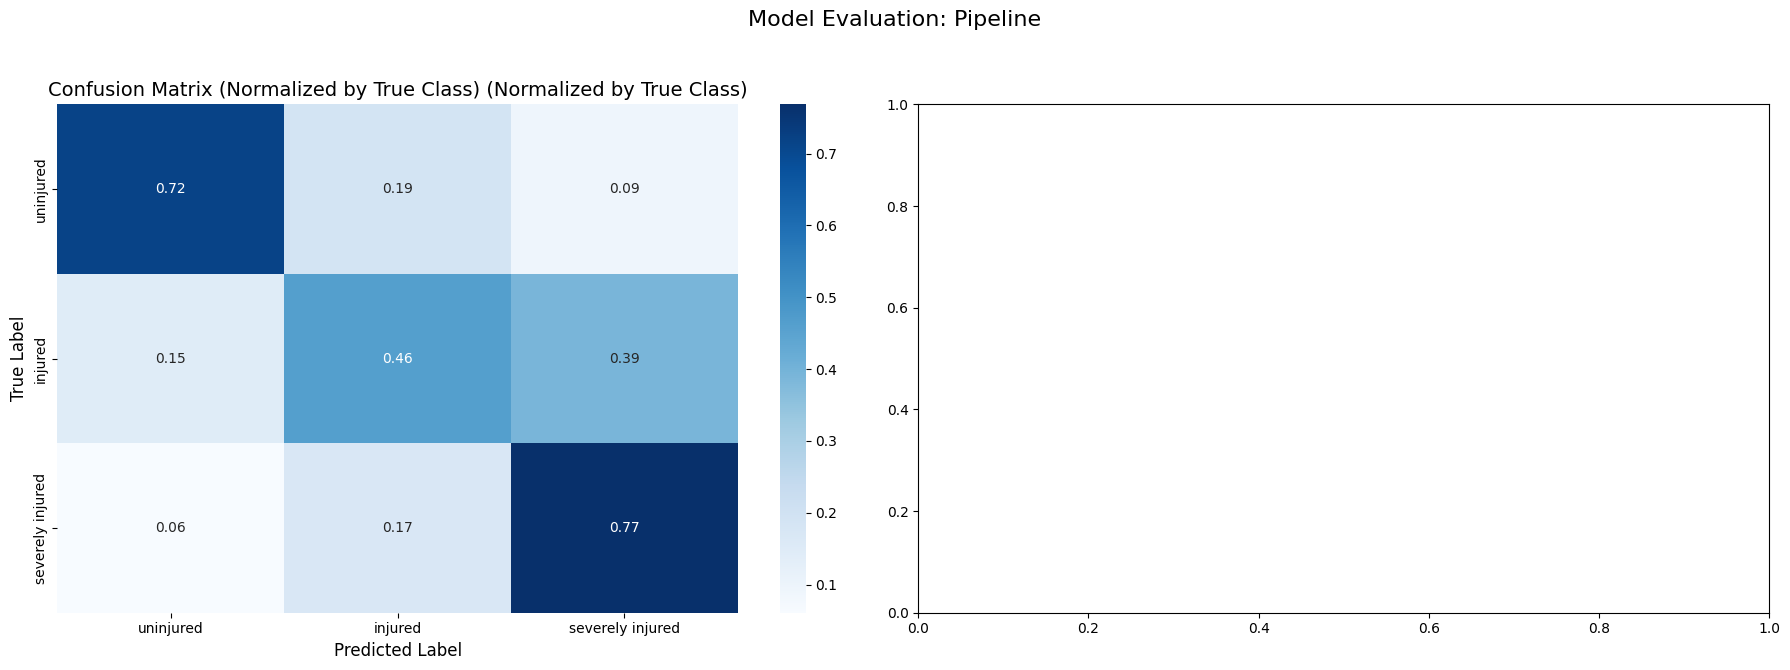

{'baseline_weighted_f1': 0.3035995907166489,
 'baseline_weighted_kappa': 0.0,
 'model_weighted_f1': 0.6419153880731023,
 'model_weighted_kappa': 0.5900415948297293}

In [14]:
from evaluation import run_classification_evaluation_non_prob

run_classification_evaluation_non_prob(pipeline_ridge_final, X_test, y_test, y_train_rebalanced, ["uninjured", "injured", "severely injured"],[0, 1, 2])

In [15]:
ord_cols = [c for c in categorical_ordered.keys() if c != 'injury_target']

transformer_random_forest = ColumnTransformer([
    ('encoder', OrdinalEncoder(unknown_value=-1, handle_unknown='use_encoded_value'), ord_cols + categorical_unordered),
], remainder='passthrough')

pipeline_balanced_random_forest = Pipeline(steps=[
    ('transformer', transformer_random_forest),
    ('classifier', BalancedRandomForestClassifier(
        max_depth=20,
        min_samples_leaf=1,
        n_estimators=1000,
        replacement=True,
        sampling_strategy='all',
        random_state=42,  
        n_jobs=-1
    ))
])

In [16]:
# Use the unbalanced dataset as it does rebalancing during bagging.
pipeline_balanced_random_forest.fit(X_train_unbalanced, y_train_unbalanced)

,steps,"[('transformer', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Calculating baseline (Most Frequent Class) performance...

--- Baseline (Most Frequent Class) Report ---
              precision    recall  f1-score   support

           0       0.47      1.00      0.64     51051
           1       0.00      0.00      0.00     39476
           2       0.00      0.00      0.00     17440

    accuracy                           0.47    107967
   macro avg       0.16      0.33      0.21    107967
weighted avg       0.22      0.47      0.30    107967

Baseline Weighted F1-Score: 0.3036
Baseline Weighted Cohen's Kappa: 0.0000
--------------------------------------------------

Evaluating model performance...

--- Model Classification Report ---
                  precision    recall  f1-score   support

       uninjured       0.88      0.72      0.79     51051
         injured       0.62      0.63      0.63     39476
severely injured       0.47      0.70      0.56     17440

        accuracy                           0.68    107967
       macro avg       0.6

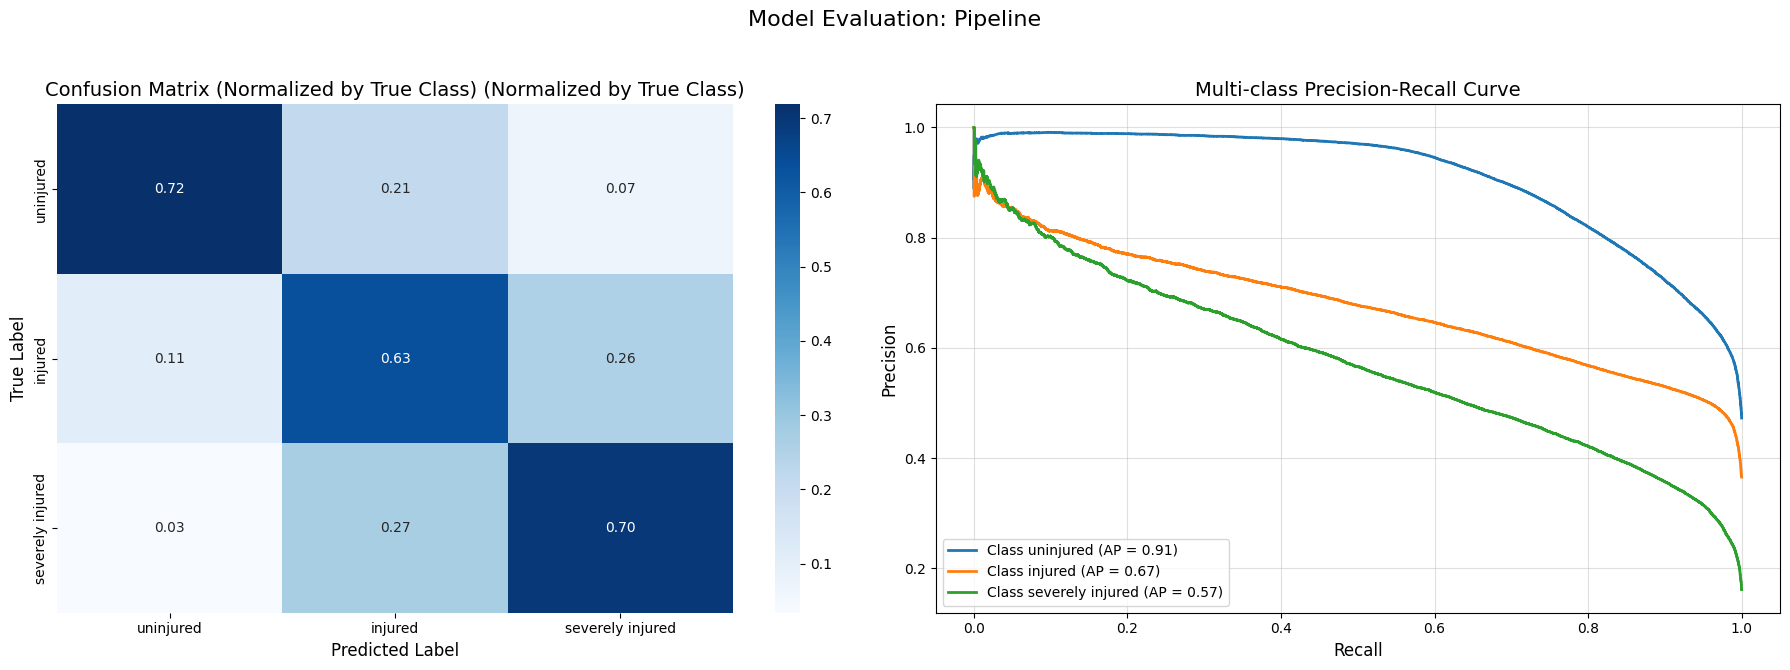

{'baseline_weighted_f1': 0.3035995907166489,
 'baseline_weighted_kappa': 0.0,
 'model_weighted_f1': 0.6938912864343332,
 'model_weighted_kappa': 0.630025035172809}

In [17]:
from evaluation import run_classification_evaluation

run_classification_evaluation(pipeline_balanced_random_forest, X_test, y_test, y_train_unbalanced, ["uninjured", "injured", "severely injured"],[0, 1, 2])

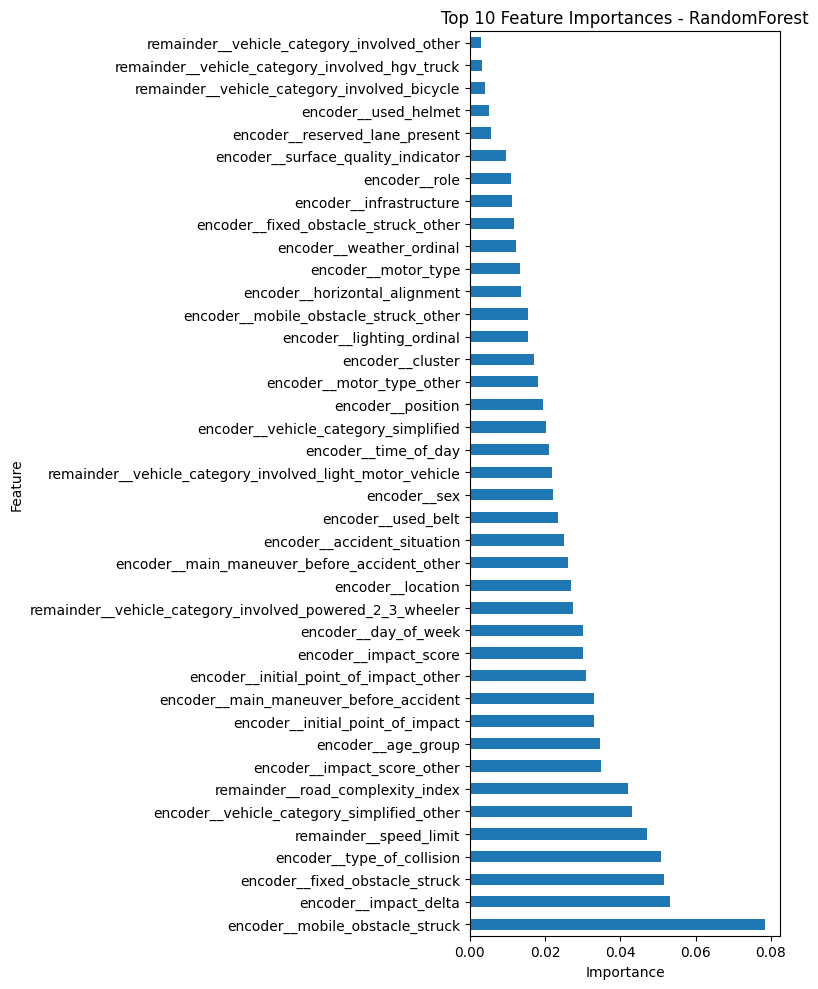

In [18]:
rf = pipeline_balanced_random_forest.named_steps["classifier"]
pre = pipeline_balanced_random_forest.named_steps["transformer"]
feature_names = pre.get_feature_names_out()

importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(8, 10))
forest_importances.nlargest(40).plot(kind="barh")
plt.title("Top 10 Feature Importances - RandomForest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [19]:
cat_idx = [i for i, (col, dt) in enumerate(X_train_rebalanced.dtypes.items()) if isinstance(dt, pd.CategoricalDtype)]

In [20]:
classifier_cat = CatBoostClassifier(
    loss_function='MultiClassOneVsAll',
    eval_metric='TotalF1:average=Macro',  # macro F1
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced',
    cat_features=cat_idx,                 # fixed, not tuned
    random_seed=42,
    verbose=0,
    border_count=255,
    depth=10,
    iterations=4139,
    l2_leaf_reg=0.18865998362606232,
    learning_rate=0.01
)

In [21]:
classifier_cat.fit(X_train_rebalanced, y_train_rebalanced)

Calculating baseline (Most Frequent Class) performance...

--- Baseline (Most Frequent Class) Report ---
              precision    recall  f1-score   support

           0       0.47      1.00      0.64     51051
           1       0.00      0.00      0.00     39476
           2       0.00      0.00      0.00     17440

    accuracy                           0.47    107967
   macro avg       0.16      0.33      0.21    107967
weighted avg       0.22      0.47      0.30    107967

Baseline Weighted F1-Score: 0.3036
Baseline Weighted Cohen's Kappa: 0.0000
--------------------------------------------------

Evaluating model performance...

--- Model Classification Report ---
                  precision    recall  f1-score   support

       uninjured       0.88      0.73      0.80     51051
         injured       0.63      0.60      0.62     39476
severely injured       0.46      0.73      0.57     17440

        accuracy                           0.68    107967
       macro avg       0.6

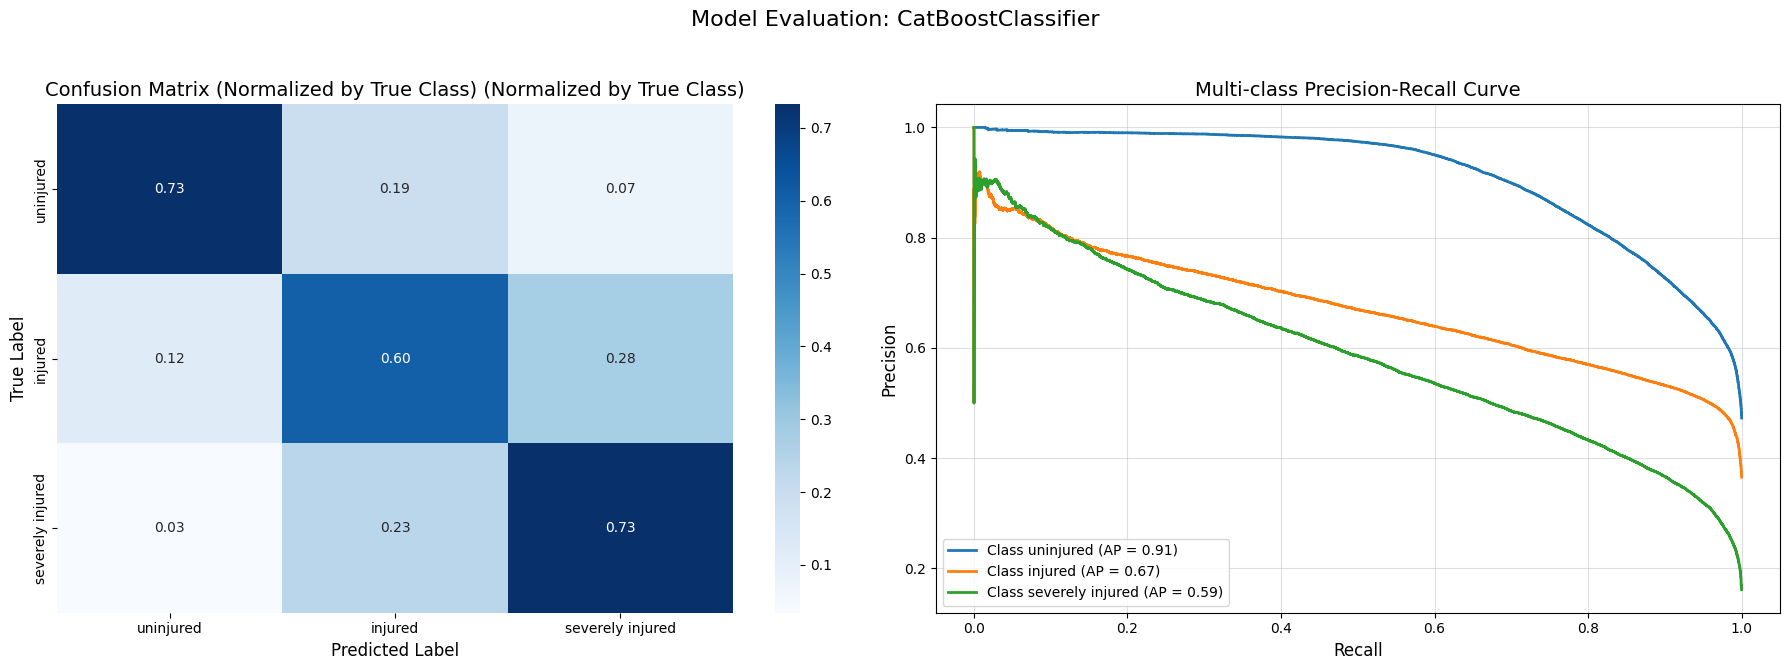

{'baseline_weighted_f1': 0.3035995907166489,
 'baseline_weighted_kappa': 0.0,
 'model_weighted_f1': 0.6940317200474541,
 'model_weighted_kappa': 0.6342113873676872}

In [22]:
run_classification_evaluation(classifier_cat, X_test, y_test, y_train_rebalanced, ["uninjured", "injured", "severely injured"],[0, 1, 2])

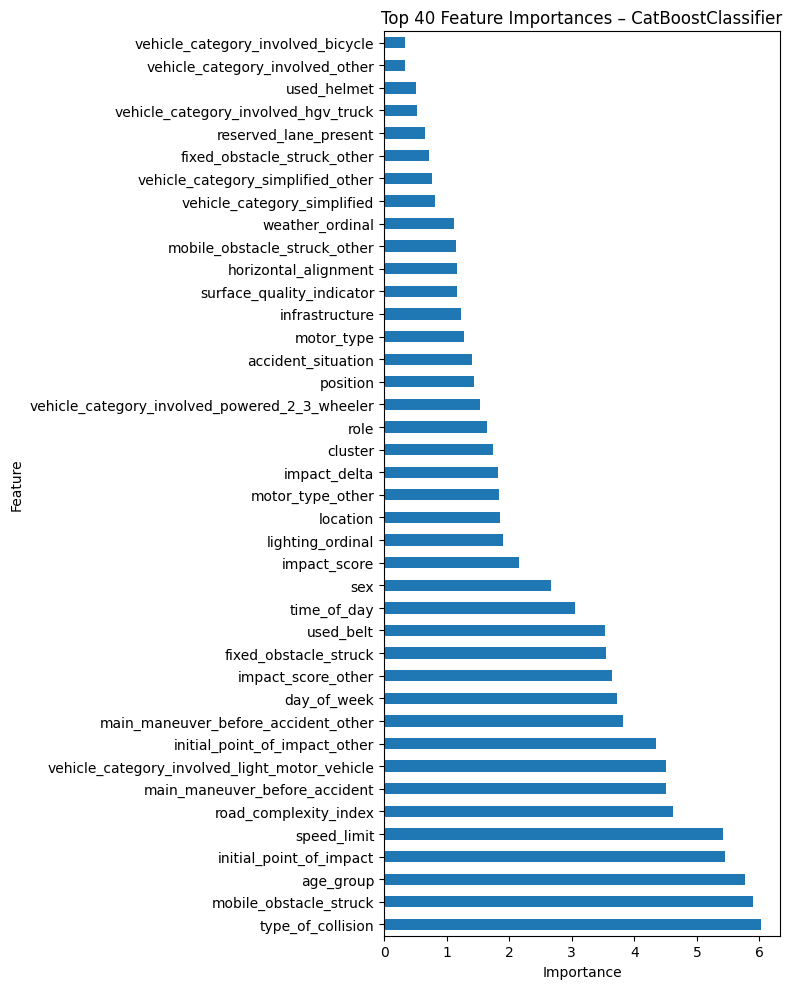

In [23]:
# Access the CatBoostClassifier directly, as it was not fitted within a pipeline
rf = classifier_cat
feature_names = X_train_rebalanced.columns # Get feature names from the original training data

# CatBoostClassifier uses get_feature_importance() method
importances = rf.get_feature_importance()
forest_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(8, 10))
# Plot top 40 features for consistency and better visualization
forest_importances.nlargest(40).plot(kind="barh")
plt.title("Top 40 Feature Importances – CatBoostClassifier") # Updated title
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

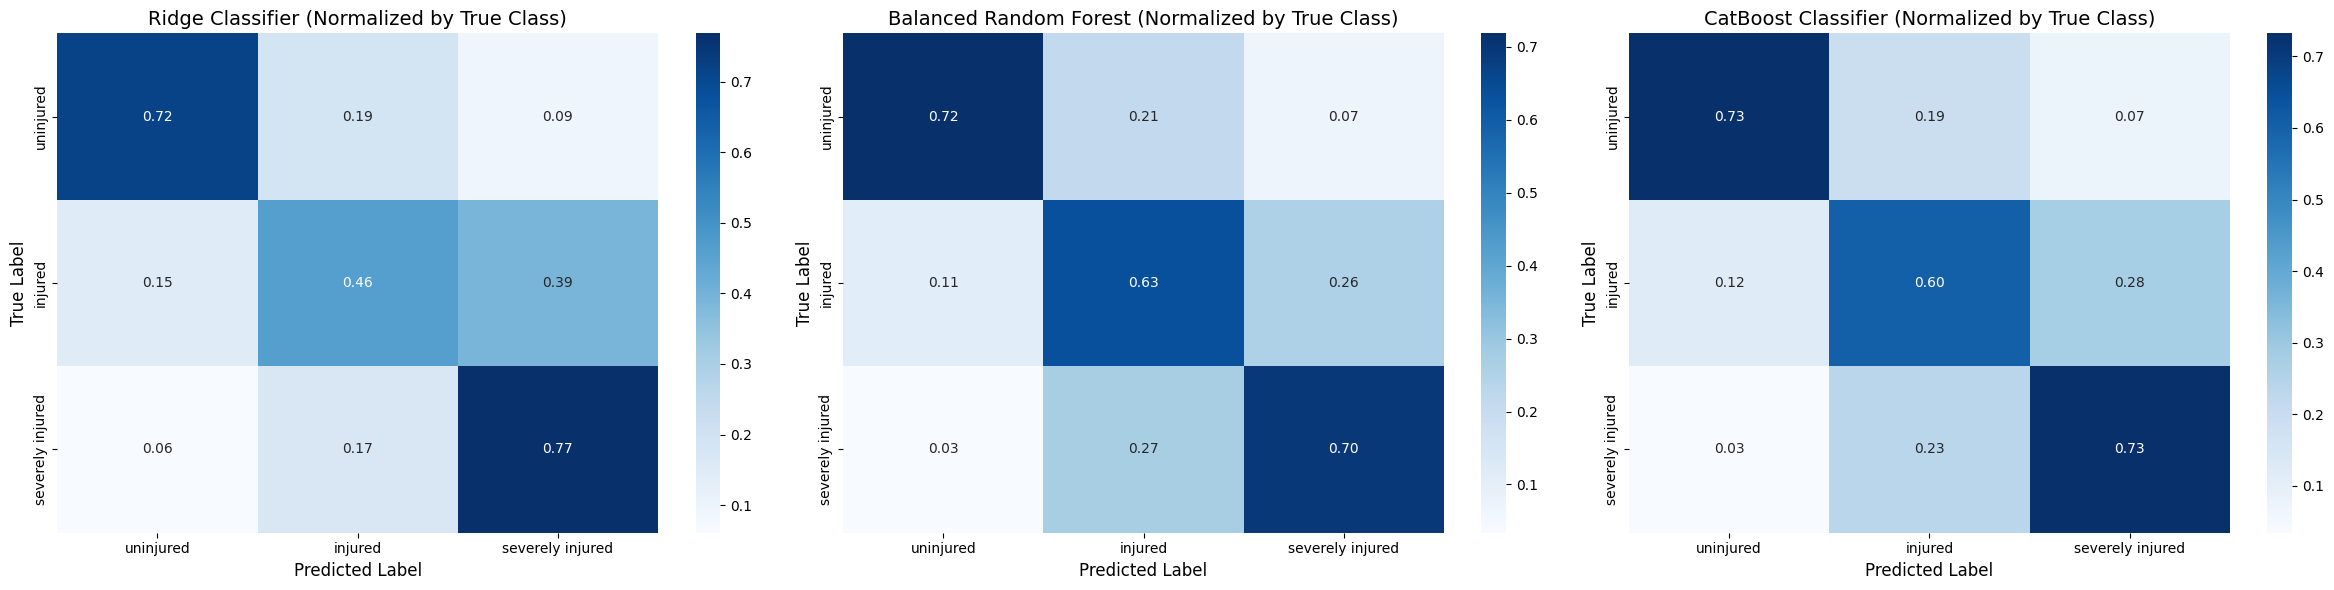

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from evaluation import plot_confusion_matrix

# Define the models and their display names
models_to_plot = [
    (pipeline_ridge_final, "Ridge Classifier"),
    (pipeline_balanced_random_forest, "Balanced Random Forest"),
    (classifier_cat, "CatBoost Classifier")
]

class_labels = ["uninjured", "injured", "severely injured"]

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for ax, (model, title) in zip(axes, models_to_plot):
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # CatBoost outputs a column vector (N, 1), flatten it to (N,)
    if hasattr(y_pred, 'ndim') and y_pred.ndim > 1:
        y_pred = y_pred.ravel()
        
    # Plot the confusion matrix using the helper function
    # normalize='true' displays the Recall (row normalization), useful for imbalanced classes
    plot_confusion_matrix(
        y_test,
        y_pred,
        class_names=class_labels,
        ax=ax,
        title=title,
        normalize='true' 
    )

plt.tight_layout()
plt.show()

In [28]:
from evaluation import plot_confusion_matrix

# ...existing code...
for ax, (model, title) in zip(axes, models_to_plot):
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # CatBoost outputs a column vector (N, 1), flatten it to (N,)
    if hasattr(y_pred, 'ndim') and y_pred.ndim > 1:
        y_pred = y_pred.ravel()
        
    # Plot the confusion matrix using the helper function
    # normalize='true' displays the Recall (row normalization), useful for imbalanced classes
    # We set cbar=False here to prevent individual bars from appearing
    plot_confusion_matrix(
        y_test,
        y_pred,
        class_names=class_labels,
        ax=ax,
        title=title,
        normalize='true',
        cbar=False
    )

# Add a single shared colorbar to the right of the subplots
# Seaborn heatmaps use QuadMesh, which is stored in .collections, not .images
fig.colorbar(axes[0].collections[0], ax=axes, fraction=0.05, shrink=0.9)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

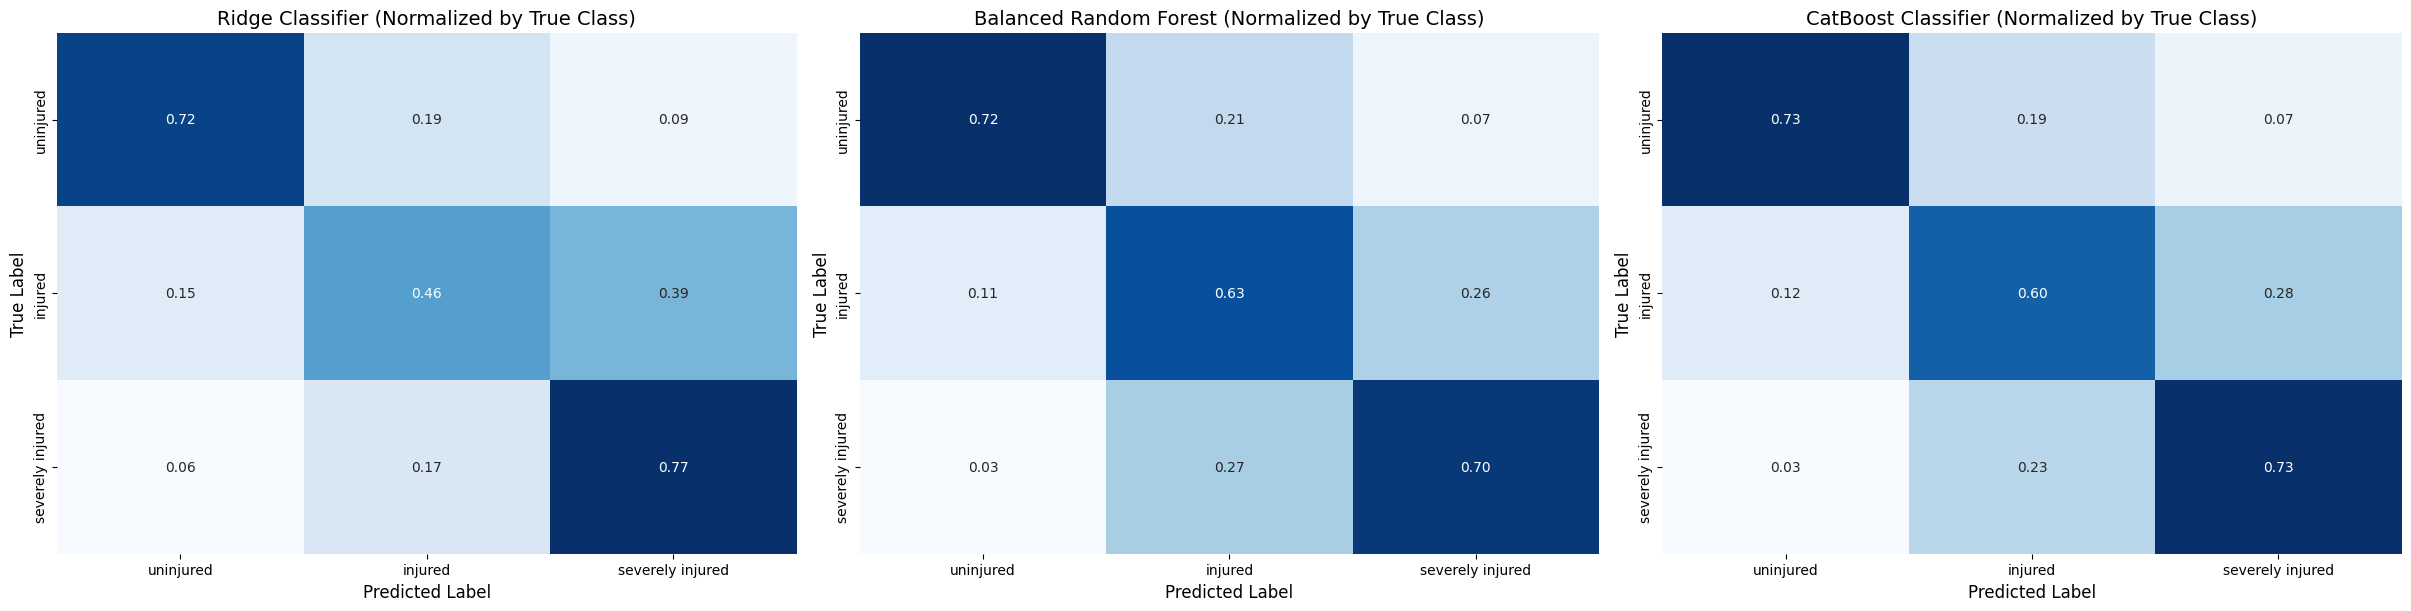

In [35]:
# ...existing code...
from evaluation import plot_confusion_matrix

# Create a figure with 3 subplots side by side
# constrained_layout=True handles the layout of shared colorbars much better than tight_layout
fig, axes = plt.subplots(1, 3, figsize=(24, 6), constrained_layout=True)

for ax, (model, title) in zip(axes, models_to_plot):
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # CatBoost outputs a column vector (N, 1), flatten it to (N,)
    if hasattr(y_pred, 'ndim') and y_pred.ndim > 1:
        y_pred = y_pred.ravel()
        
    # Plot the confusion matrix using the helper function
    plot_confusion_matrix(
        y_test,
        y_pred,
        class_names=class_labels,
        ax=ax,
        title=title,
        normalize='true',
        cbar=False
    )

# Add a single shared colorbar to the right of the subplots
# pad=0.01 brings it closer to the plots (default is usually around 0.05 or 0.15 depending on context)
#fig.colorbar(axes[0].collections[0], ax=axes, fraction=0.05, shrink=0.9, pad=0.01)

# Save the figure as an SVG
plt.savefig('confusion_matrices_comparison.svg', format='svg', bbox_inches='tight')
plt.savefig('confusion_matrices_comparison.pdf', format='pdf', bbox_inches='tight')

plt.show()